In [1]:
import pandas as pd 
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score
from sklearn.linear_model import LassoCV


In [2]:
# Load the dataset
df = pd.read_csv('churn_clean.csv', index_col=0)
#Check Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [3]:
df.head(5)

,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,...,172.455519,904.536110,5,5,5,3,4,4,3,4
2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,...,242.632554,800.982766,3,4,3,3,4,3,4,4
3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [4]:
# Handle missing values and outliers
print("Initial Missing Values:")
print(df.isnull().sum())

# Identify columns with missing values
columns_with_missing = df.columns[df.isnull().any()]

# Replace missing values or drop rows/columns as needed
# Impute missing values for numerical columns (replace with mean)
for col in columns_with_missing:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].fillna(df[col].mean(), inplace=True)

# Impute missing values for categorical columns (replace with mode)
for col in columns_with_missing:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
# Display information about missing values after imputation
print("\nMissing Values After Imputation:")
print(df.isnull().sum())

Initial Missing Values:
Customer_id                0
Interaction                0
UID                        0
City                       0
State                      0
County                     0
Zip                        0
Lat                        0
Lng                        0
Population                 0
Area                       0
TimeZone                   0
Job                        0
Children                   0
Age                        0
Income                     0
Marital                    0
Gender                     0
Churn                      0
Outage_sec_perweek         0
Email                      0
Contacts                   0
Yearly_equip_failure       0
Techie                     0
Contract                   0
Port_modem                 0
Tablet                     0
InternetService         2129
Phone                      0
Multiple                   0
OnlineSecurity             0
OnlineBackup               0
DeviceProtection           0
TechSupport        

In [5]:
#Categorical Columns to Numeric
categorical_columns = ['Techie','Port_modem','Churn','OnlineSecurity','DeviceProtection', 'TechSupport', 'PaperlessBilling', 'Tablet', 'Phone', 'Multiple', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']
for column in categorical_columns:
    df[column] = df[column].map({'Yes': 1, 'No': 0})

In [6]:
#Format
df['Age'] = df['Age'].fillna(0).astype(int)
df['Lng'] = df['Lng'].fillna(0).abs()

In [7]:
area_mapping = {'Urban': 0,'Suburban': 1,'Rural': 2}
marital_mapping = {'Widowed': 0,'Married': 1,'Separated': 2,'Never Married': 3,'Divorced' :4}
gender_mapping = {'Male':0,'Female': 1,'Prefer not to answer': 2}
contract_mapping = {'One year': 0,'Month-to-month': 1,'Two Year': 2}
InternetService_mapping = {'DSL': 0,'Fiber Optic': 1,'None': 2}
PaymentMethod_mapping = {'Bank Transfer(automatic)': 0,'Credit Card (automatic)': 1,'Mailed Check': 2, 'Electronic Check': 3}



df['Area'] = df['Area'].map(area_mapping)
df['Marital'] = df['Marital'].map(marital_mapping)
df['Gender'] = df['Gender'].map(gender_mapping)
df['Contract'] = df['Contract'].map(contract_mapping)
df['InternetService'] = df['InternetService'].map(InternetService_mapping)
df['PaymentMethod'] = df['PaymentMethod'].map(PaymentMethod_mapping)

In [8]:
#Missing Values
df['Gender']= df['Gender'].fillna(df['Gender'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  int64  
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int32  
 15  Income                10

In [9]:
regress_df=df[['Churn','MonthlyCharge','Gender', 'Age', 'Income', 'DeviceProtection', 'Tenure', 'Bandwidth_GB_Year', 'Contacts', 'Yearly_equip_failure', 'Item4', 'Item5', 'Item6', 'Item7']]

In [10]:
# Save the cleaned dataset to a new CSV file
regress_df.to_csv('cleaned_churn_data.csv', index=False)

In [11]:
# Load the new dataset
data = pd.read_csv('cleaned_churn_data.csv')
#Check Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Churn                 10000 non-null  int64  
 1   MonthlyCharge         10000 non-null  float64
 2   Gender                10000 non-null  float64
 3   Age                   10000 non-null  int64  
 4   Income                10000 non-null  float64
 5   DeviceProtection      10000 non-null  int64  
 6   Tenure                10000 non-null  float64
 7   Bandwidth_GB_Year     10000 non-null  float64
 8   Contacts              10000 non-null  int64  
 9   Yearly_equip_failure  10000 non-null  int64  
 10  Item4                 10000 non-null  int64  
 11  Item5                 10000 non-null  int64  
 12  Item6                 10000 non-null  int64  
 13  Item7                 10000 non-null  int64  
dtypes: float64(5), int64(9)
memory usage: 1.1 MB


In [12]:
# Summary dependent
data['Churn'].value_counts()
data['Churn'].describe()


count    10000.000000
mean         0.265000
std          0.441355
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Churn, dtype: float64

In [13]:
# Summary dependent
data['Gender'].value_counts()
data['Gender'].describe()


count    10000.000000
mean         0.525600
std          0.499369
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Gender, dtype: float64

In [14]:
# Summary dependent
data['Age'].value_counts()
data['Age'].describe()


count    10000.000000
mean        53.078400
std         20.698882
min         18.000000
25%         35.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64

In [15]:
# Summary dependent
data['Income'].value_counts()
data['Income'].describe()


count     10000.000000
mean      39806.926771
std       28199.916702
min         348.670000
25%       19224.717500
50%       33170.605000
75%       53246.170000
max      258900.700000
Name: Income, dtype: float64

In [16]:
# Summary dependent
data['MonthlyCharge'].value_counts()
data['MonthlyCharge'].describe()


count    10000.000000
mean       172.624816
std         42.943094
min         79.978860
25%        139.979239
50%        167.484700
75%        200.734725
max        290.160419
Name: MonthlyCharge, dtype: float64

In [17]:
# Summary dependent
data['Tenure'].value_counts()
data['Tenure'].describe()


count    10000.000000
mean        34.526188
std         26.443063
min          1.000259
25%          7.917694
50%         35.430507
75%         61.479795
max         71.999280
Name: Tenure, dtype: float64

In [18]:
# Summary dependent
data['Bandwidth_GB_Year'].value_counts()
data['Bandwidth_GB_Year'].describe()


count    10000.000000
mean      3392.341550
std       2185.294852
min        155.506715
25%       1236.470827
50%       3279.536903
75%       5586.141370
max       7158.981530
Name: Bandwidth_GB_Year, dtype: float64

In [19]:
# Summary dependent
data['Contacts'].value_counts()
data['Contacts'].describe()


count    10000.000000
mean         0.994200
std          0.988466
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: Contacts, dtype: float64

In [20]:
# Summary dependent
data['Yearly_equip_failure'].value_counts()
data['Yearly_equip_failure'].describe()

count    10000.000000
mean         0.398000
std          0.635953
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          6.000000
Name: Yearly_equip_failure, dtype: float64

In [21]:
# Summary dependent
data['Item4'].value_counts()
data['Item4'].describe()

count    10000.000000
mean         3.497500
std          1.025816
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: Item4, dtype: float64

In [22]:
# Summary dependent
data['Item5'].value_counts()
data['Item5'].describe()

count    10000.000000
mean         3.492900
std          1.024819
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: Item5, dtype: float64

In [23]:
# Summary dependent
data['Item6'].value_counts()
data['Item6'].describe()

count    10000.000000
mean         3.497300
std          1.033586
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          8.000000
Name: Item6, dtype: float64

In [24]:
# Summary dependent
data['Item7'].value_counts()
data['Item7'].describe()

count    10000.000000
mean         3.509500
std          1.028502
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          7.000000
Name: Item7, dtype: float64

In [25]:
# Summary independent variables
independent_variables = ['Gender', 'Age', 'Income', 'MonthlyCharge', 'Tenure', 'Bandwidth_GB_Year', 'Contacts', 'Yearly_equip_failure', 'Item4', 'Item5', 'Item6', 'Item7']
data[independent_variables].describe()

,Gender,Age,Income,MonthlyCharge,Tenure,Bandwidth_GB_Year,Contacts,Yearly_equip_failure,Item4,Item5,Item6,Item7
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.525600,53.078400,39806.926771,172.624816,34.526188,3392.341550,0.994200,0.398000,3.497500,3.492900,3.497300,3.509500
std,0.499369,20.698882,28199.916702,42.943094,26.443063,2185.294852,0.988466,0.635953,1.025816,1.024819,1.033586,1.028502
min,0.000000,18.000000,348.670000,79.978860,1.000259,155.506715,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,35.000000,19224.717500,139.979239,7.917694,1236.470827,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000
50%,1.000000,53.000000,33170.605000,167.484700,35.430507,3279.536903,1.000000,0.000000,3.000000,3.000000,3.000000,4.000000
75%,1.000000,71.000000,53246.170000,200.734725,61.479795,5586.141370,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000
max,1.000000,89.000000,258900.700000,290.160419,71.999280,7158.981530,7.000000,6.000000,7.000000,7.000000,8.000000,7.000000


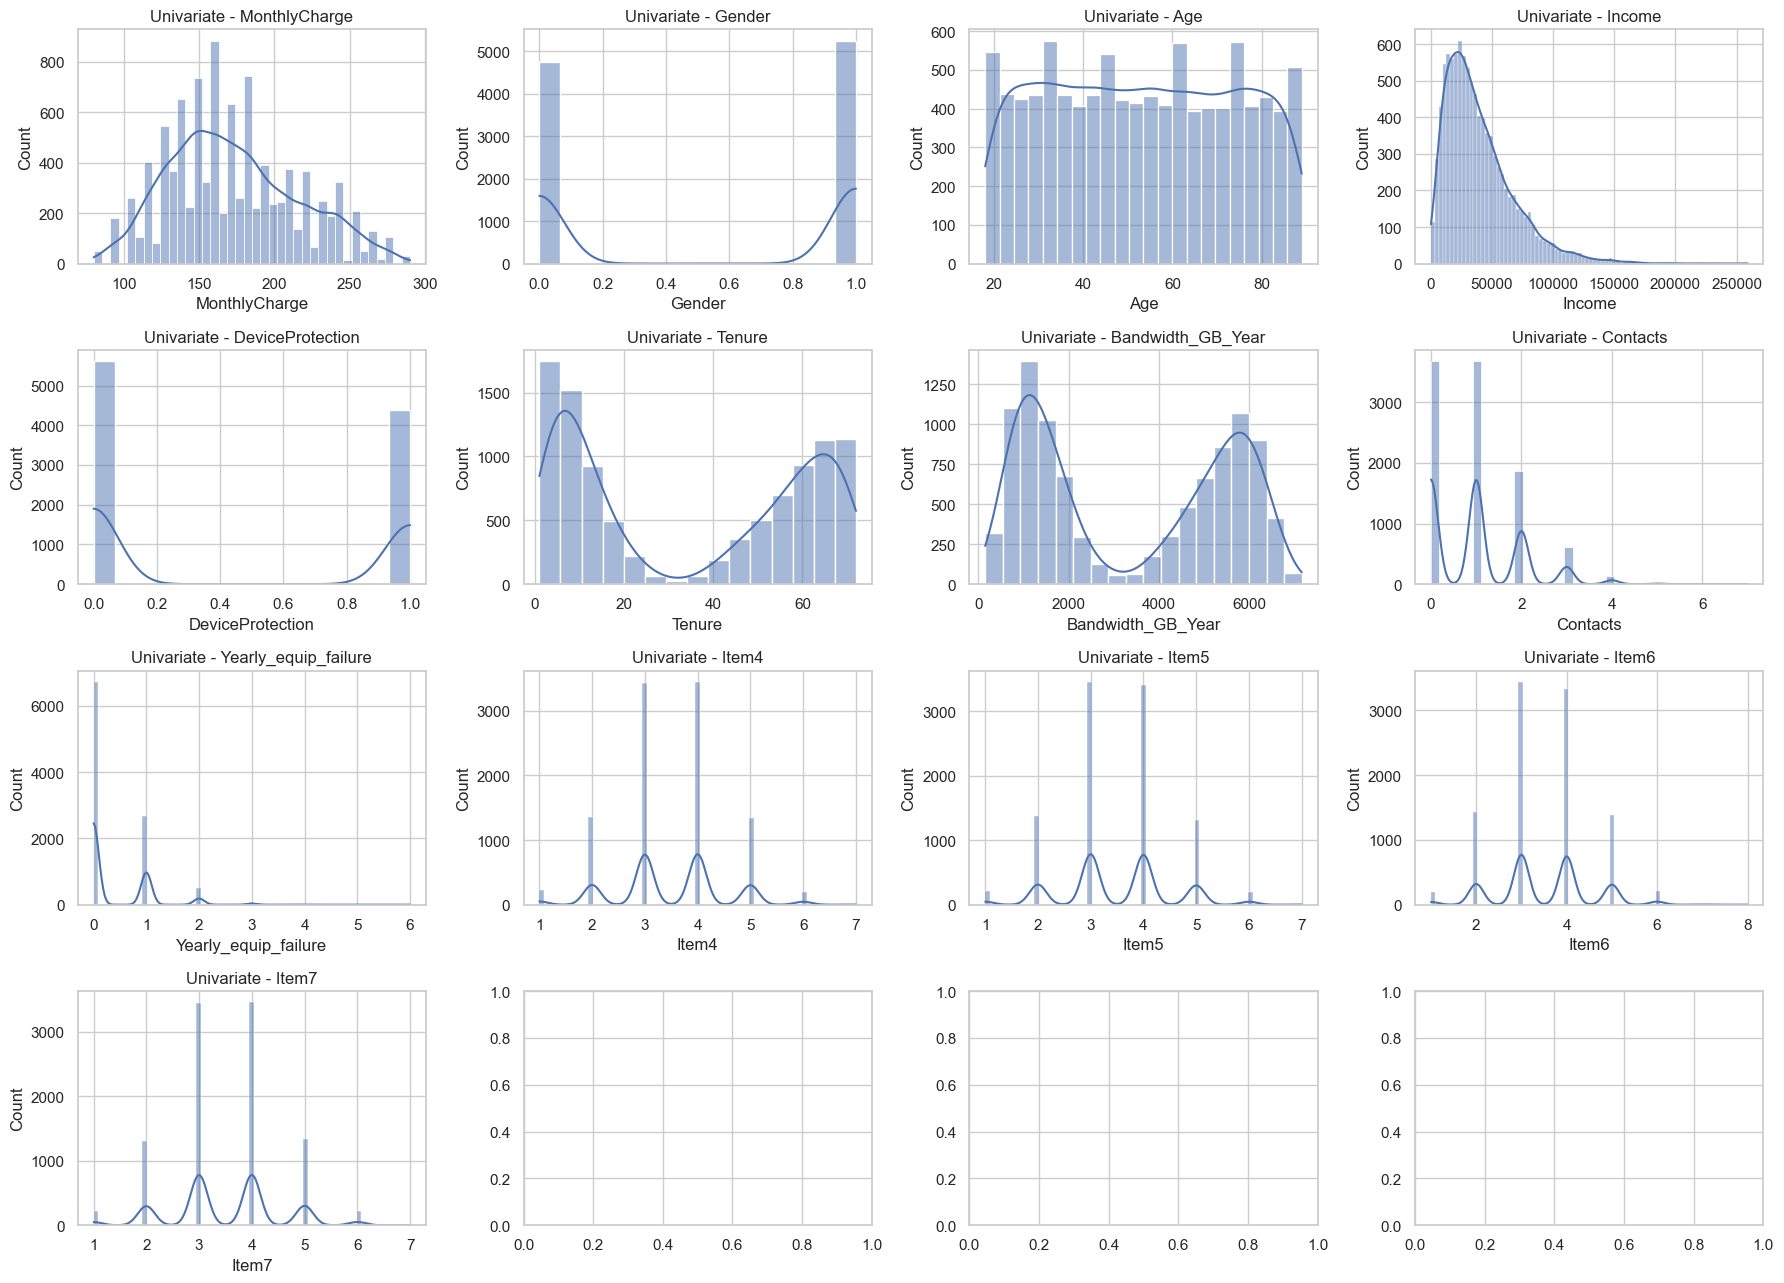

In [26]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Select variables for analysis
variables = ['MonthlyCharge', 'Gender', 'Age', 'Income', 'DeviceProtection', 'Tenure', 'Bandwidth_GB_Year', 'Contacts', 'Yearly_equip_failure', 'Item4', 'Item5', 'Item6', 'Item7']

# Calculate the number of rows and columns for subplots
num_variables = len(variables)
num_rows = (num_variables - 1) // 4 + 1  # Calculate the number of rows needed
num_cols = min(4, num_variables)  # Use 4 columns or the number of variables, whichever is smaller

# Univariate Visualizations
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 13))

for i, var in enumerate(variables):
    sns.histplot(data[var], kde=True, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(f'Univariate - {var}')

plt.tight_layout()
plt.show()

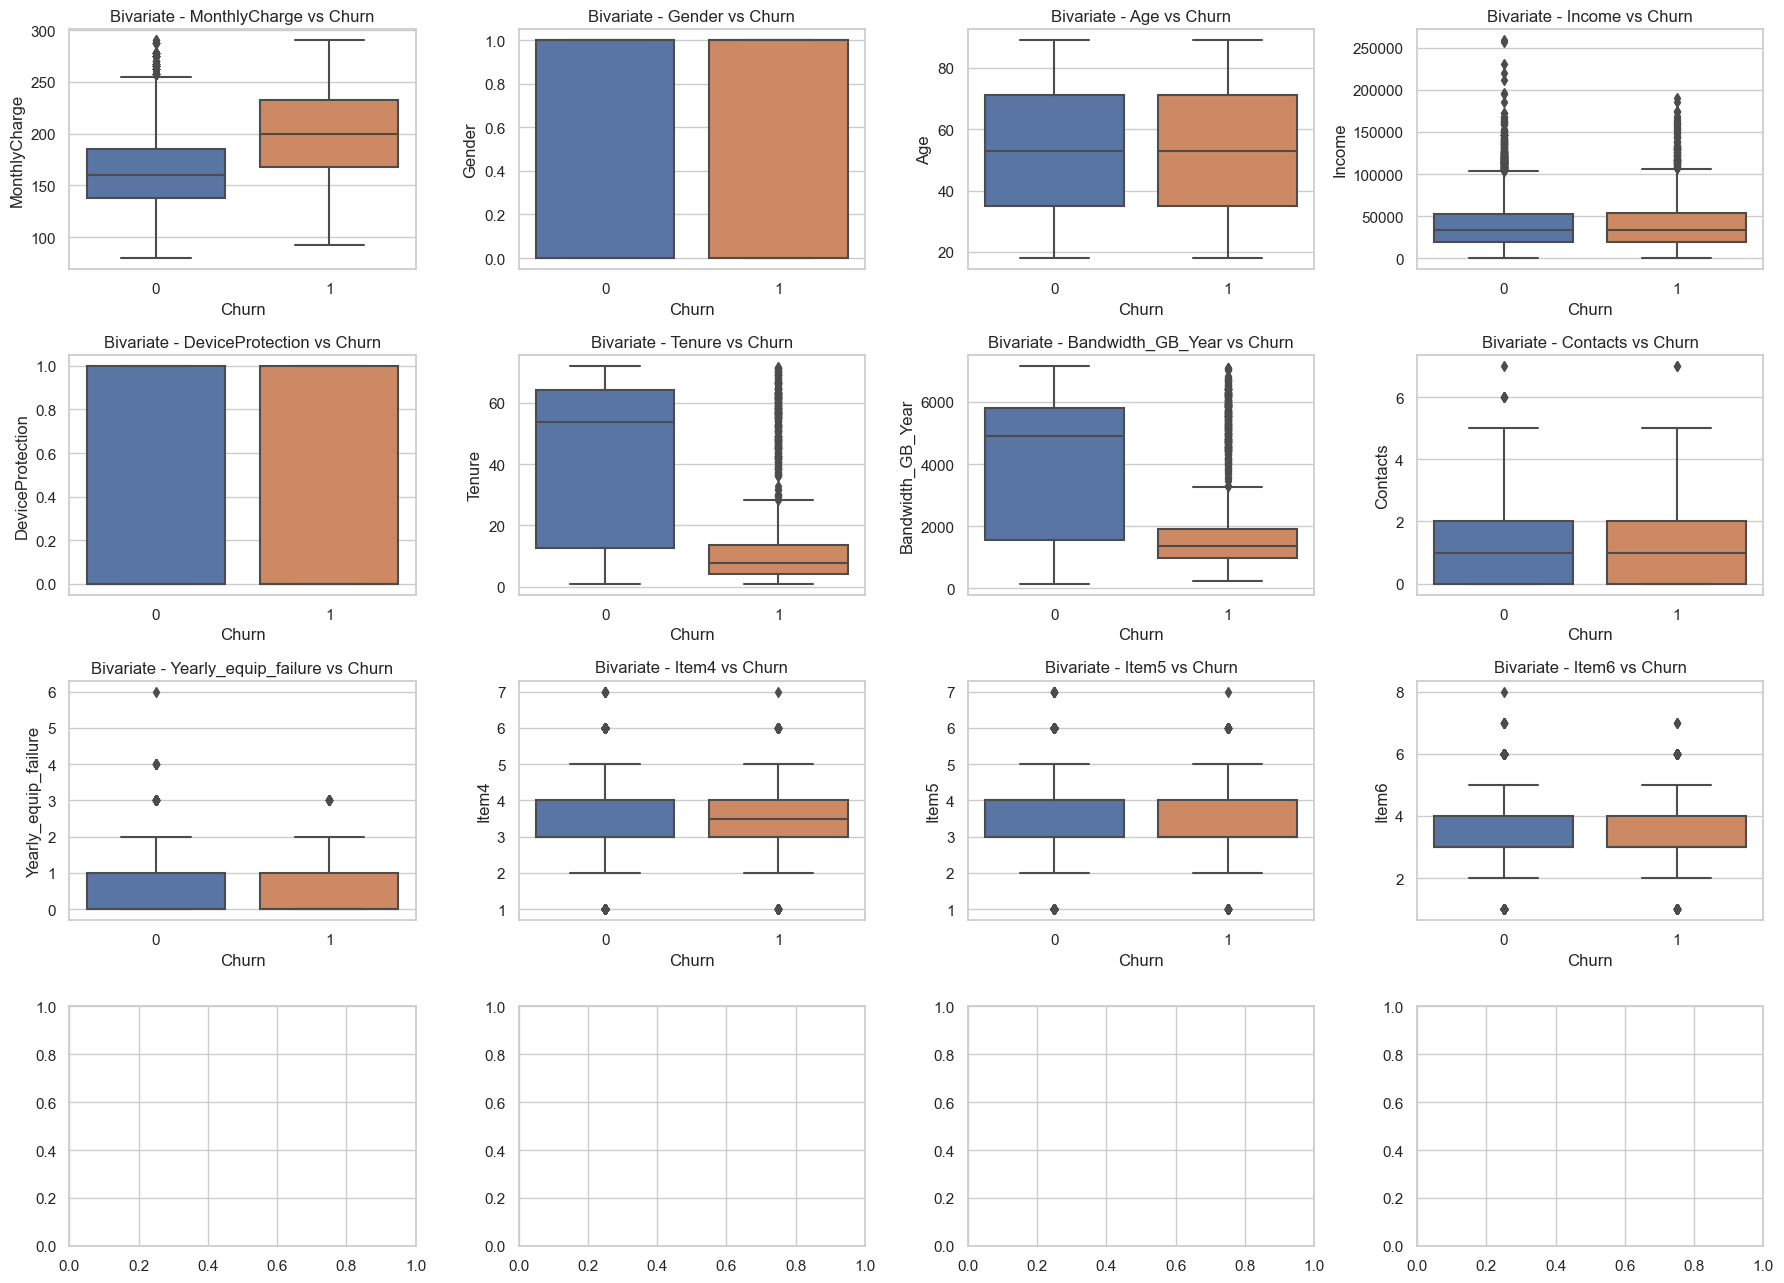

In [27]:
# Bivariate Visualizations
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 13))

# Use all variables for bivariate visualizations
for i, var in enumerate(variables[:-1]):
    sns.boxplot(x='Churn', y=var, data=data, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(f'Bivariate - {var} vs Churn')

plt.tight_layout()
plt.show()

In [28]:

X_selected = data[['MonthlyCharge', 'Gender', 'Age', 'Income', 'DeviceProtection', 'Tenure', 'Bandwidth_GB_Year', 'Contacts', 'Yearly_equip_failure', 'Item4', 'Item5', 'Item6', 'Item7']]
y = data['Churn']
X_selected = sm.add_constant(X_selected)
model_selected = sm.OLS(y, X_selected)


logit_model=sm.Logit(y,X_selected)
results_selected=logit_model.fit()
print(results_selected.summary())

Optimization terminated successfully.
         Current function value: 0.320730
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9986
Method:                           MLE   Df Model:                           13
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.4453
Time:                        14:53:39   Log-Likelihood:                -3207.3
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.6220      0.316    -17.777      0.000      -6.242      -5.002

In [29]:
# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# Display the VIF values
print(vif_data)

                Variable        VIF
0                  const  95.437414
1          MonthlyCharge   1.366686
2                 Gender   1.027901
3                    Age   1.093418
4                 Income   1.002221
5       DeviceProtection   1.037985
6                 Tenure  87.152593
7      Bandwidth_GB_Year  87.423289
8               Contacts   1.000405
9   Yearly_equip_failure   1.000525
10                 Item4   1.261828
11                 Item5   1.332686
12                 Item6   1.245088
13                 Item7   1.208334


In [30]:
# Function to calculate VIF and drop variables with VIF above a threshold
def calculate_vif(data, threshold=11):
    variables = list(range(data.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(data.iloc[:, variables].values, i) for i in range(data.iloc[:, variables].shape[1])]
        max_vif = max(vif)
        if max_vif > threshold:
            max_vif_index = vif.index(max_vif)
            del variables[max_vif_index]
            dropped = True
    remaining_vars = data.columns[variables]
    return data[remaining_vars]

# Apply VIF-based feature selection
X_vif_filtered = calculate_vif(X_selected, threshold=200)

# Fit Lasso regression model on the filtered features
lasso_model = LassoCV()
lasso_model.fit(X_vif_filtered, y)

# Get selected feature coefficients
selected_coeffs = lasso_model.coef_

# Get selected feature names
selected_features_lasso = X_vif_filtered.columns[selected_coeffs != 0]

# Display selected features using Lasso
print("Selected Features (Lasso):", selected_features_lasso)

Selected Features (Lasso): Index(['MonthlyCharge', 'Income', 'Bandwidth_GB_Year'], dtype='object')


In [31]:
X_selected = data[['MonthlyCharge', 'Age', 'Income', 'Tenure']]

# Add a constant term for the intercept
X_selected = sm.add_constant(X_selected)
y = data['Churn']

# Fit logistic regression model
logit_model = sm.Logit(y, X_selected)
results_selected = logit_model.fit()

# Display summary
print(results_selected.summary())

Optimization terminated successfully.
         Current function value: 0.342000
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.4085
Time:                        14:53:39   Log-Likelihood:                -3420.0
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.2677      0.175    -30.182      0.000      -5.610      -4.926
MonthlyCharge     0.

In [32]:
X_selected = data[['MonthlyCharge', 'Age', 'DeviceProtection', 'Tenure', 'Bandwidth_GB_Year']]

# Add a constant term for the intercept
X_selected = sm.add_constant(X_selected)
y = data['Churn']

# Fit logistic regression model
logit_model = sm.Logit(y, X_selected)
results_selected = logit_model.fit()

# Display summary
print(results_selected.summary())

Optimization terminated successfully.
         Current function value: 0.320993
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                  0.4449
Time:                        14:53:39   Log-Likelihood:                -3209.9
converged:                       True   LL-Null:                       -5782.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.0371      0.185    -32.711      0.000      -6.399      -5.675
MonthlyC

In [33]:
y_true = data['Churn']
y_pred_prob = results_selected.predict(X_selected)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[6792  558]
 [ 966 1684]]
Accuracy: 0.8476
